In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

In [3]:
UC_Sampled = pd.read_csv('datasets/uncontrollable_sample.csv', index_col='id')
df_controllable_sampled = pd.read_csv('datasets/controllable_sampled.csv', index_col = 'id')

In [4]:
df_controllable_all = pd.read_csv('Faizan_scratch/Controllables/controllable_cleaned_features.csv', index_col='id')

In [5]:
df_uncontrollable_all = pd.read_csv('Faizan_scratch/uncontrollable_cleaned_features.csv', index_col='id')

In [6]:
df_all_features = df_controllable_all.merge(df_uncontrollable_all, left_index=True, right_index=True)

In [7]:
df_all_features = df_all_features.drop(columns=['host_is_superhost', 'Label_y'])

In [8]:
df_all_features = df_all_features.rename(columns={'Label_x':'Label'})

In [9]:
uncontrollable_columns = UC_Sampled.drop(columns='Label').columns
controllable_columns = df_controllable_sampled.drop(columns='Label').columns

# ULTIMATE BAKEOFF

## Uncontrollable

In [10]:


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm, linear_model


#Best models:

best_rf_uc = RandomForestClassifier(criterion='entropy', n_estimators=200, 
                                    max_features=11, oob_score=True,min_samples_leaf=61,min_samples_split=1402)
best_gb_uc = GradientBoostingClassifier(learning_rate=0.05, max_depth=7, max_features='sqrt',
                           min_samples_leaf=0.24545454545454548,
                           min_samples_split=0.42727272727272736,
                           n_estimators=1000, subsample=0.9)
best_dt_uc = DecisionTreeClassifier(criterion = 'gini', min_samples_leaf=180, min_samples_split=1050)
best_svm_uc = svm.SVC(kernel = 'rbf', C = 0.2681812609453013)
best_lr_uc = linear_model.LogisticRegression(C = 10**-1.5, penalty = 'l1', max_iter = 4000, solver = 'saga')


models = {'RF': best_rf_uc, 'GB' : best_gb_uc, 'DT' : best_dt_uc, 'SVM': best_svm_uc, 'LR': best_lr_uc}


In [12]:
from sklearn.model_selection import train_test_split

X = df_all_features[uncontrollable_columns]
Y = df_all_features['Label']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.80)

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns = uncontrollable_columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = uncontrollable_columns)

In [18]:
for model in models:
    models[model].fit(X_train, Y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [19]:
predictions_rf = best_rf_uc.predict_proba(X_test[uncontrollable_columns])[:,1]
predictions_gb = best_gb_uc.predict_proba(X_test[uncontrollable_columns])[:,1]
predictions_dt = best_dt_uc.predict_proba(X_test[uncontrollable_columns])[:,1]
predictions_svm = best_svm_uc.decision_function(X_test[uncontrollable_columns])
predictions_lr = best_lr_uc.predict_proba(X_test[uncontrollable_columns])[:,1]

predictions = {'RF': predictions_rf, 'GB' : predictions_gb, 'DT' : predictions_dt, 'SVM': predictions_svm, 'LR': predictions_lr}



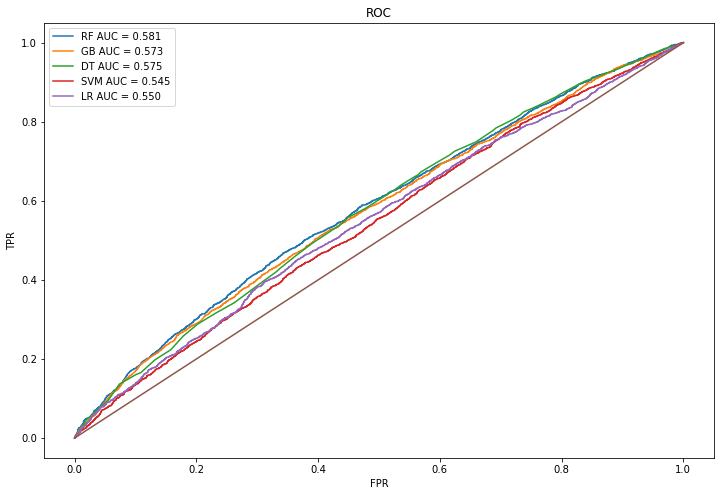

In [20]:
#Plot ROC curves of the two models

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, svm, metrics


plt.figure(figsize=(12,8))

for prediction in predictions:
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions[prediction])
    auc = metrics.auc(fpr,tpr)
    label = prediction + " AUC = %.3f"%auc
    plt.plot(fpr,tpr,label = label)
    

#Plot 45 degree line
plt.plot([0,1],[0,1])

plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

plt.show()

## Controllable

In [21]:
best_rf_c = RandomForestClassifier(criterion='entropy', max_features=8,
                       min_samples_split=100, n_estimators=160)
best_gb_c = GradientBoostingClassifier(n_estimators=100, max_depth=5,max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  min_samples_split=1000,
                                                  random_state=10,
                                                  subsample=0.8)
best_dt_c = DecisionTreeClassifier(criterion = 'gini', min_samples_leaf=40, min_samples_split=350)
best_svm_c = svm.SVC(kernel = 'rbf',  C = 0.24175940791691308)
best_lr_c = linear_model.LogisticRegression(solver = 'saga', penalty = 'l1', max_iter = 2000, C = 0.20151357338155584)

models = {'RF': best_rf_c, 'GB' : best_gb_c, 'DT' : best_dt_c, 'SVM': best_svm_c, 'LR': best_lr_c}

In [22]:
X = df_all_features[controllable_columns]
Y = df_all_features['Label']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.80)

In [23]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns = controllable_columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = controllable_columns)

In [24]:
for model in models:
    models[model].fit(X_train, Y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [25]:
predictions_rf = best_rf_c.predict_proba(X_test[controllable_columns])[:,1]
predictions_gb = best_gb_c.predict_proba(X_test[controllable_columns])[:,1]
predictions_dt = best_dt_c.predict_proba(X_test[controllable_columns])[:,1]
predictions_svm = best_svm_c.decision_function(X_test[controllable_columns])
predictions_lr = best_lr_c.predict_proba(X_test[controllable_columns])[:,1]

predictions = {'RF': predictions_rf, 'GB' : predictions_gb, 'DT' : predictions_dt, 'SVM': predictions_svm, 'LR': predictions_lr}


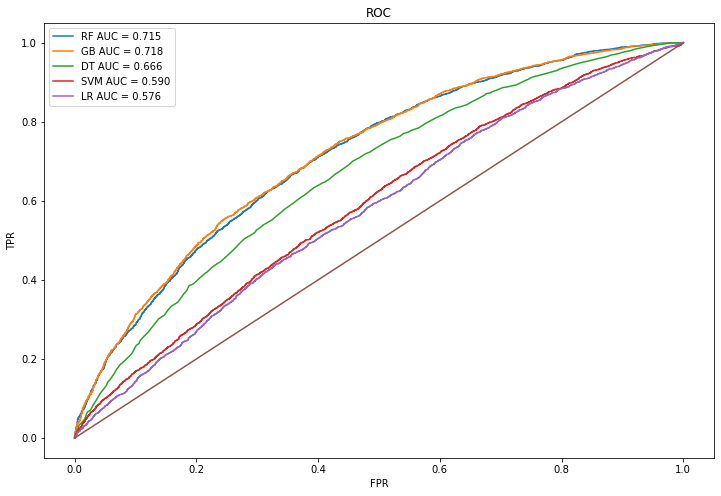

In [26]:
#Plot ROC curves of the two models

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, svm, metrics


plt.figure(figsize=(12,8))

for prediction in predictions:
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions[prediction])
    auc = metrics.auc(fpr,tpr)
    label = prediction + " AUC = %.3f"%auc
    plt.plot(fpr,tpr,label = label)
    

#Plot 45 degree line
plt.plot([0,1],[0,1])

plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

plt.show()

## Winners: 

### Controllable: 

RandomForestClassifier(criterion='entropy', max_features=8,
                       min_samples_split=100, n_estimators=160)


### Uncontrollable:

RandomForestClassifier(criterion='entropy', n_estimators=200, 
                                    max_features=11, oob_score=True,min_samples_leaf=61,min_samples_split=1402)

## Leveraging Uncontrollable and Controllable models

Basic Idea: Each location gets 2 scores - a location score and a property/quality score. We can bucket the listings into 4 buckets based on score combos

In [376]:
#Take the full dataset and split into train and test:

from sklearn.model_selection import train_test_split

X = df_all_features.drop(columns=['Label'])
Y = df_all_features['Label']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.80)

In [378]:
#Train the location model and the property model on the Train dataset using best model parameters


uncontrollable_columns = UC_Sampled.drop(columns='Label').columns
rf_uncontrollable = RandomForestClassifier(criterion='entropy', n_estimators=200, 
                                    max_features=11, oob_score=True,min_samples_leaf=61,min_samples_split=1402)
fit = rf_uncontrollable.fit(X_train[uncontrollable_columns], Y_train)

controllable_columns = df_controllable_sampled.drop(columns='Label').columns
rf_controllable = RandomForestClassifier(criterion='entropy', max_features=8,
                       min_samples_split=100, n_estimators=160)
fit = rf_controllable.fit(X_train[controllable_columns], Y_train)

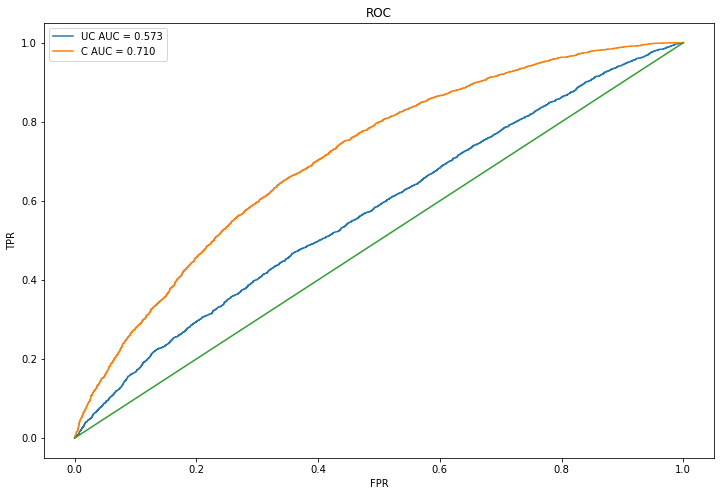

In [379]:
#Plot ROC curves of the two models

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, svm, metrics

predictions_rf_uc = rf_uncontrollable.predict_proba(X_test[uncontrollable_columns])[:,1]
predictions_rf_c = rf_controllable.predict_proba(X_test[controllable_columns])[:,1]


plt.figure(figsize=(12,8))

#Plot LR ROC/AUC
fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions_rf_uc)
auc = metrics.auc(fpr,tpr)
label = "UC AUC = %.3f"%auc
plt.plot(fpr,tpr,label = label)

#Plot LR ROC/AUC
fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions_rf_c)
auc = metrics.auc(fpr,tpr)
label = "C AUC = %.3f"%auc
plt.plot(fpr,tpr,label = label)


#Plot 45 degree line
plt.plot([0,1],[0,1])

plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

plt.show()

In [380]:
df_test_with_predictions = pd.DataFrame(Y_test)

In [381]:
df_test_with_predictions['Location_predictions_score'] = rf_uncontrollable.predict_proba(X_test[uncontrollable_columns])[:,1]
df_test_with_predictions['Property_predictions_score'] = rf_controllable.predict_proba(X_test[controllable_columns])[:,1]


In [382]:
df_test_with_predictions['Loc_bucket'] = pd.qcut(df_test_with_predictions['Location_predictions_score'], 3, labels=["low", "medium", "high"])

df_test_with_predictions['Prop_bucket'] = pd.qcut(df_test_with_predictions['Property_predictions_score'], 3, labels=["low", "medium", "high"])


In [383]:
statistics = df_test_with_predictions.groupby(['Loc_bucket', 'Prop_bucket']).agg(['mean', 'count'])['Label']

In [384]:
statistics['percent'] = statistics['count'] / len(df_test_with_predictions)

In [385]:
statistics

mean  count   percent
Loc_bucket Prop_bucket                           
low        low          0.232350   1119  0.140560
           medium       0.475787    826  0.103756
           high         0.644570    709  0.089059
medium     low          0.249431    878  0.110288
           medium       0.497256    911  0.114433
           high         0.659722    864  0.108529
high       low          0.336377    657  0.082527
           medium       0.534934    916  0.115061
           high         0.708603   1081  0.135787

<table style="height: 306px;" width="637">
<tbody>
<tr>
<td style="width: 152px;">&nbsp;</td>
<td style="width: 152px; text-align: center;"><strong>High Property Score</strong></td>
<td style="width: 152px; text-align: center;"><strong>Medium Property Score</strong></td>
<td style="width: 153px; text-align: center;"><strong>Low Property Score</strong></td>
</tr>
<tr>
<td style="width: 152px; text-align: center;"><strong>High Location Score</strong></td>
<td style="width: 152px;">
<p>Percent of Listings: 12.1%</p>
<p>% Actual Positives: 66.3%</p>
</td>
<td style="width: 152px;">
<p>Percent of Listings: 10.7%</p>
<p>% Actual Positives: 57.4%</p>
</td>
<td style="width: 153px;">
<p>Percent of Listings: 8.6%</p>
<p>% Actual Positives: 37.7%</p>
</td>
</tr>
<tr>
<td style="width: 152px; text-align: center;"><strong>Medium Location Score</strong></td>
<td style="width: 152px;">Percent of Listings: 10.9%
<p>% Actual Positives: 61.6%</p>
</td>
<td style="width: 152px;">Percent of Listings: 11.0%
<p>% Actual Positives: 50.2%</p>
</td>
<td style="width: 153px;">Percent of Listings: 11.1%
<p>% Actual Positives: 34.9%</p>
</td>
</tr>
<tr>
<td style="width: 152px; text-align: center;"><strong>Low Location Score</strong></td>
<td style="width: 152px;">
<p>Percent of Listings: 9.8%</p>
<p>% Actual Positives: 60.5%</p>
</td>
<td style="width: 152px;">
<p>Percent of Listings: 11.5%</p>
<p>% Actual Positives: 45.4%</p>
</td>
<td style="width: 153px;">
<p>Percent of Listings: 14.3%</p>
<p>% Actual Positives: 25.5%</p>
</td>
</tr>
</tbody>
</table>